<a href="https://colab.research.google.com/github/DNAOBN/CDadosSeg/blob/master/TG_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TG - Processamento de Imagens

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

# Importação de bibliotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Constantes e Dicionários

In [ ]:
DRIVE_PATH = "/content/drive"

# Accepted image extensions
IMAGE_FORMATS = (".png", ".jpg", ".jpeg")

# Path to the synthetic training images and their labels
IMAGE_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/dataset"
LABEL_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/label"

# Path to augmented synthetic training images and their labels
IMAGE_AUGMENTATION_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/dataset_augmentation"
LABEL_AUGMENTATION_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/label_augmentation"

# Path to the real testing images and their labels
IMAGE_TEST_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/dataset_test"
LABEL_TEST_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/label_test"

# Selected labels
# sky (clouds)
# mountain
# water (river, sea)
# grass
# tree (tipo floresta)



PREDICTION_PATH = f"{DRIVE_PATH}/My Drive/UFPR/TCC/prediction"
BRUSHES = {
    96:  0,   # Bush 
    148: 5,   # Road
    149: 5,   # Rock
    161: 5,   # Stone
    105: 1,   # Cloud
    134: 2,   # Mountain
    177: 3,   # Water
    147: 3,   # River
    154: 3,   # Sea
    156: 1,   # Sky
    118: 0,   # Flower
    123: 0,   # Grass
    168: 4,   # Tree
}
COLORS = {
    # 0: [96,110,50],   # Bush 
    # # 0: [148,110,40],   # Road
    # 8: [149,100,50],   # Rock
    # 7: [161,161,100],   # Stone
    # 1: [105,105,105],   # Cloud
    # 3: [177,200,255],   # Water
    # 9: [147,100,200],   # River
    # 3: [154,198,218],   # Sea
    # # 5: [118,0,0],   # Flower
    0: [123,200,0],   # Grass
    # 6: [168,200,50],   # Tree

    # 0: [96,110,50],   # Bush 
    # 0: [148,110,40],   # Road
    # 8: [149,100,50],   # Rock
    # 7: [161,161,100],   # Stone
    # 1: [105,105,105],   # Cloud
    2: [134,150,100],   # Mountain
    3: [177,200,255],   # Water
    # 9: [147,100,200],   # River
    # 3: [154,198,218],   # Sea
    1: [156,238,221],   # Sky
    # 5: [118,0,0],   # Flower
    4: [168,200,50]   # Tree
}

# Funções para leitura da entrada

In [ ]:
def read_images(filenames):
  images_list = []
  for filename in filenames:
    images_list.append(
      cv2.cvtColor(cv2.imread(filename, -1), cv2.COLOR_BGR2RGB)
    )  
    # https://stackoverflow.com/questions/39316447/opencv-giving-wrong-color-to-colored-images-on-loading
  return images_list

def get_dir_filenames(path):
    filenames = []
    for file in os.listdir(path):
        if file.endswith(IMAGE_FORMATS):
            filenames.append(f"{path}/{file}")
    return filenames

In [ ]:
images_filenames = get_dir_filenames(IMAGE_PATH) #+ get_dir_filenames(IMAGE_AUGMENTATION_PATH)
label_filenames = get_dir_filenames(LABEL_PATH) #+ get_dir_filenames(LABEL_AUGMENTATION_PATH)

images_filenames.sort()
label_filenames.sort()

images_test_filenames = get_dir_filenames(IMAGE_TEST_PATH)
label_test_filenames = get_dir_filenames(LABEL_TEST_PATH)

images_test_filenames.sort()
label_test_filenames.sort()

# print(len(label_filenames))
# print(len(images_filenames))

# Funções de tratamento das imagens

In [ ]:
def normalize(images):
  # images = tf.cast(images, tf.float32) / 255.0
  return images

def resize(images):
  images = tf.image.resize(images, (128, 128), method='nearest')
  return images

def extract_channel(images, channel=0, size=128):
  output = []
  for image in images:
    single_channel = np.zeros((size,size,1))
    single_channel[:,:,0] = image[:,:,0]
    output.append(single_channel)
  return output

def convert_back(images, size=128):
  output = []
  for image in images:
    new_image = np.zeros((size, size, 3))
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        new_image[i][j] = get_rgb_from_brush(image[i][j])
    output.append(new_image)
  return output

# Returns the corresponding brush
# based on a pixel's value
def get_brush_from_pixel(pixel):
  return BRUSHES.get(pixel) or 0

# Returns the brush's corresponding
# rgb value
def get_rgb_from_brush(pixel):
  rgb = COLORS.get(pixel[0])
  return np.array(rgb or [0,0,0])

convert_pixel_vec = np.vectorize(get_brush_from_pixel)
# convert_pixel_back_vec = np.vectorize(get_rgb_from_brush)


In [ ]:
images = resize(read_images(images_filenames))
labels_original = resize(read_images(label_filenames))

images_test = resize(read_images(images_test_filenames))
labels_test_original = resize(read_images(label_test_filenames))

# labels = convert_pixel_vec(extract_channel(labels_original))
# labels = []
# images = read_images(images_filenames)
# labels_original = read_images(label_filenames)
# for image in extract_channel(labels_original):
#   labels.append(convert_pixel_vec(image))

labels = convert_pixel_vec(extract_channel(labels_original))
labels_test = convert_pixel_vec(extract_channel(labels_test_original))

In [ ]:
# print(len(images))
# print(len(labels))

# print(images[0].shape)
# print(labels[0].shape)

# Funções para impressão das imagens

In [ ]:
def show_comparisons(images, labels):
    if (len(images) != len(labels)):
        raise Exception("Error: Images does not match the labels.")
    rows = len(images)
    for i in range(rows):
      print(np.unique(labels[i]))
      display([images[i], labels[i]])

def display(display_list):
  plt.figure(figsize=(5, 5))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i == 0:
      plt.imshow(display_list[i])
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Imprime imagens

In [ ]:
# show_comparisons(labels_original, convert_back(labels))

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]
print (layers)
# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):

  # Esta é a última camada do modelo
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', activation='softmax')  #64x64 -> 128x128

  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling através do modelo
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling e estabelecimento das conexões de salto
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(len(BRUSHES))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'block_1_expand_relu')>, <KerasTensor: shape=(None, 32, 32, 144) dtype=float32 (created by layer 'block_3_expand_relu')>, <KerasTensor: shape=(None, 16, 16, 192) dtype=float32 (created by layer 'block_6_expand_relu')>, <KerasTensor: shape=(None, 8, 8, 576) dtype=float32 (created by layer 'block_13_expand_relu')>, <KerasTensor: shape=(None, 4, 4, 320) dtype=float32 (created by layer 'block_16_project')>]


In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True)


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def count_each_pixel(image):
  brushes, counts = np.unique(image, return_counts=True)
  for i in range(len(brushes)):
    print(f"Brush: {brushes[i]} | Count: {counts[i]}")

def show_predictions(dataset=None):
  if dataset !=None:
    for image, label in zip(dataset, labels):
      pred_mask = model.predict(image[tf.newaxis, ...])
      mask = create_mask(pred_mask)
      # count_each_pixel(label)
      # print("=================================")
      # count_each_pixel(mask)
      display([image, label, mask])
  else: 
    # caso o dataset nao seja selecionado, imprime uma imagem exemplo com o modelo nao treinado
    for image in prediction_data: 
      pred_mask = model.predict(image[tf.newaxis, ...])
      mask = create_mask(pred_mask)
      # count_each_pixel(mask)
      display([image, convert_back([np.array(mask)])[0]])


prediction_filenames = get_dir_filenames(PREDICTION_PATH)

prediction_data_b = read_images(prediction_filenames)
prediction_data = []
for image in prediction_data_b :
  prediction_data.append(resize(image)) 

# show_predictions(images)

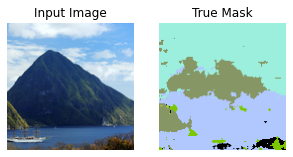

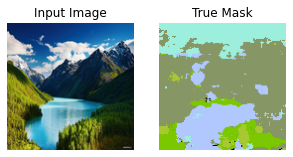

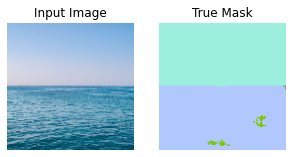

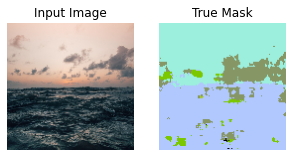

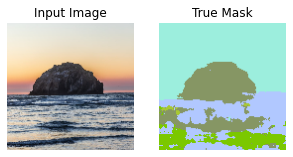

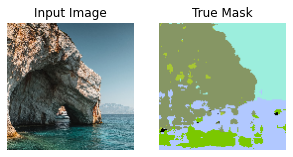

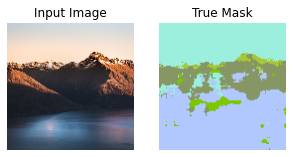

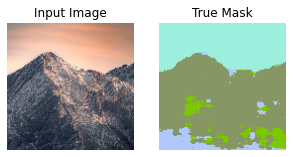

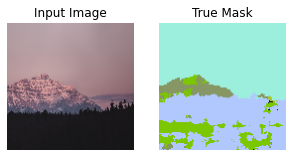

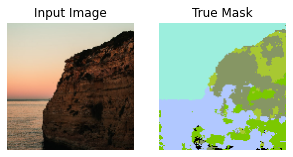

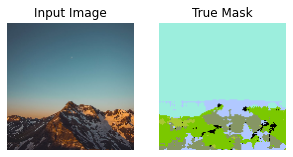

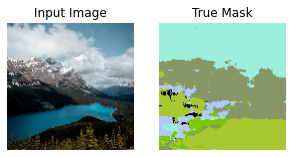

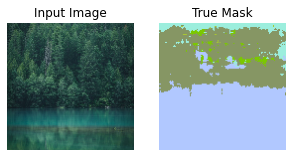

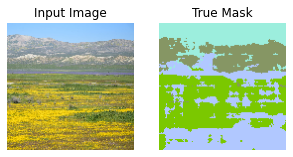

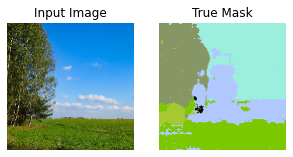

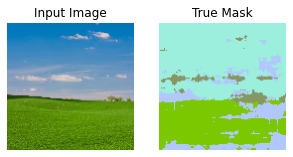

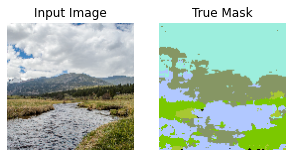

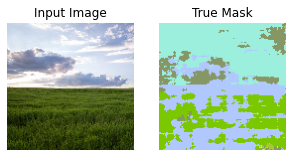

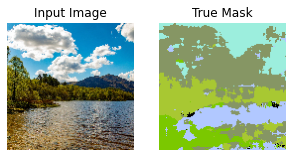

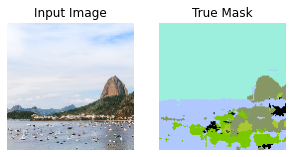

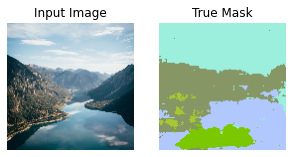

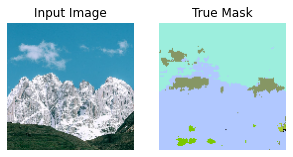

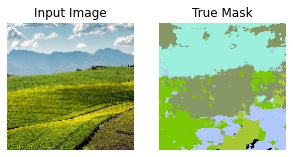

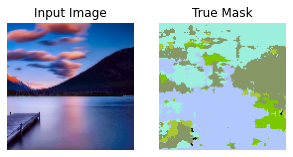

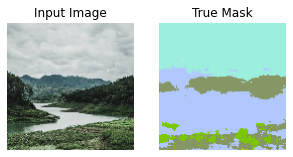

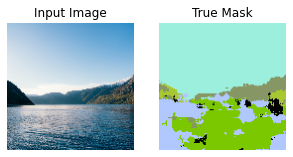

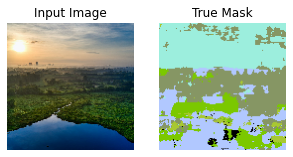


Sample Prediction after epoch 20



In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

EPOCHS = 20

model_history = model.fit(np.array(images).reshape(-1, 128, 128, 3), np.array(labels), epochs=EPOCHS, steps_per_epoch=len(images), callbacks=[DisplayCallback()])

In [ ]:
print("Evaluate on test data")
results = model.evaluate(images_test, labels_test)

print("test loss, test acc:", results)


In [ ]:
show_predictions(images)

In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()